In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch
import torchvision
import torchaudio
import lightgbm as lgb
import xgboost as xgb
import imblearn
import scipy
import statsmodels.api as sm
import openpyxl
import shap
import plotly
import lifelines
import optuna

In [2]:
# Atlassian Brand Colours
atlassian_colors = [
    "#0052CC",  # Atlassian Blue (primary)
    "#2684FF",  # Bright Blue
    "#57D9A3",  # Green accent
    "#FFAB00",  # Gold accent
    "#FF5630",  # Red accent
    "#36B37E",  # Secondary green
    "#6554C0"   # Purple accent
]

# Set Global Theme
sns.set_theme(
    style="whitegrid",
    palette=atlassian_colors,
    rc={
        "figure.figsize": (10, 6),
        "axes.titlesize": 18,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "axes.edgecolor": "#DFE1E6",  # Atlassian light gray
        "axes.linewidth": 1.0,
        "axes.facecolor": "white",
        "figure.facecolor": "white"
    }
)

In [3]:
billing_df = pd.read_csv('../datasets/billing.csv')
events_df = pd.read_csv('../datasets/events.csv')
sessions_df = pd.read_csv('../datasets/sessions.csv')
users_df = pd.read_csv('../datasets/users.csv')


In [4]:
if 'session_start' in sessions_df.columns:
    sessions_df['session_start'] = pd.to_datetime(sessions_df['session_start'], errors='coerce')
if 'ts' in events_df.columns:
    events_df['ts'] = pd.to_datetime(events_df['ts'], errors='coerce')


# ===============================
# 1. Aggregate sessions
# ===============================
sessions_agg_user = sessions_df.groupby("user_id").agg(
    total_sessions=("session_id", "count"),
    avg_session_length=("session_length_sec", "mean"),
    total_session_length=("session_length_sec", "sum"),
    most_common_device=("device", lambda x: x.mode()[0] if not x.mode().empty else None),
    most_common_os=("os", lambda x: x.mode()[0] if not x.mode().empty else None),
).reset_index()

# Add monthly aggregation for user-month dataset
sessions_agg_month = sessions_df.groupby(["user_id", sessions_df["session_start"].dt.to_period("M")]).agg(
    total_sessions=("session_id", "count"),
    avg_session_length=("session_length_sec", "mean"),
    total_session_length=("session_length_sec", "sum")
).reset_index().rename(columns={"session_start": "month"})
sessions_agg_month["month"] = sessions_agg_month["month"].astype(str)

# ===============================
# 2. Aggregate events
# ===============================
events_agg_user = events_df.groupby("user_id").agg(
    total_events=("event_id", "count"),
    avg_event_duration=("duration_ms", "mean"),
    avg_latency=("latency_ms", "mean"),
    success_rate=("success", "mean")
).reset_index()

events_agg_month = events_df.groupby(["user_id", events_df["ts"].dt.to_period("M")]).agg(
    total_events=("event_id", "count"),
    avg_event_duration=("duration_ms", "mean"),
    avg_latency=("latency_ms", "mean"),
    success_rate=("success", "mean")
).reset_index().rename(columns={"ts": "month"})
events_agg_month["month"] = events_agg_month["month"].astype(str)

# ===============================
# 3. Billing aggregation
# ===============================
billing_agg_user = billing_df.groupby("user_id").agg(
    avg_mrr=("mrr", "mean"),
    total_mrr=("mrr", "sum"),
    max_mrr=("mrr", "max"),
    avg_active_seats=("active_seats", "mean"),
    total_support_tickets=("support_ticket_count", "sum"),
    invoices_overdue=("invoices_overdue", "sum"),
    discount_used=("discount_applied", "sum")
).reset_index()

# billing_df already works for user-month dataset

# ===============================
# 4. Merge into final datasets
# ===============================
# --- User-level dataset ---
user_level = (
    users_df
    .merge(sessions_agg_user, on="user_id", how="left")
    .merge(events_agg_user, on="user_id", how="left")
    .merge(billing_agg_user, on="user_id", how="left")
)

# --- User-month dataset ---
user_month = (
    billing_df
    .merge(users_df, on="user_id", how="left")
    .merge(sessions_agg_month, on=["user_id", "month"], how="left")
    .merge(events_agg_month, on=["user_id", "month"], how="left")
)

# ===============================
# 5. Save or inspect
# ===============================
print("User-level dataset shape:", user_level.shape)
print("User-month dataset shape:", user_month.shape)

user_level.head()


User-level dataset shape: (100000, 28)
User-month dataset shape: (1000176, 26)


,user_id,signup_date,plan_tier,company_size,region,industry,acquisition_channel,is_enterprise,churned_30d,churned_90d,...,avg_event_duration,avg_latency,success_rate,avg_mrr,total_mrr,max_mrr,avg_active_seats,total_support_tickets,invoices_overdue,discount_used
0,f94d1824-8742-4000-8b6d-39d70958490b,2024-05-13,free,11-50,EU,software,seo,False,0,0,...,NaN,NaN,NaN,0.000000,0.0,0.0,1.466667,0,0,0
1,238bf0af-1f71-45e4-a47d-dcb5db33f71b,2025-04-11,standard,1-10,NaN,education,seo,False,0,0,...,NaN,NaN,NaN,8.000000,32.0,8.0,1.000000,0,0,0
2,ccf8fc06-3c86-433c-8867-9cba0fda337b,2024-10-28,free,1-10,APAC,transport,partner,False,0,0,...,NaN,NaN,NaN,0.000000,0.0,0.0,1.800000,0,0,0
3,3e39c0ea-ebbf-43bc-abd5-ab92eff6fa10,2024-05-17,standard,200+,APAC,software,partner,False,0,0,...,1144.142857,291.642857,1.0,790.826667,11862.4,1024.0,101.533333,30,0,2
4,9304dcbe-682d-41fa-8bfd-861559f9f58b,2024-04-12,free,1-10,NaN,software,ads,False,0,1,...,NaN,NaN,NaN,0.000000,0.0,0.0,1.500000,0,1,0


In [14]:
user_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000176 entries, 0 to 1000175
Data columns (total 26 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   user_id               1000176 non-null  object 
 1   month                 1000176 non-null  object 
 2   plan_tier_x           1000176 non-null  object 
 3   active_seats          1000176 non-null  int64  
 4   mrr                   1000176 non-null  float64
 5   discount_applied      1000176 non-null  int64  
 6   invoices_overdue      1000176 non-null  int64  
 7   support_ticket_count  1000176 non-null  int64  
 8   signup_date           1000176 non-null  object 
 9   plan_tier_y           1000176 non-null  object 
 10  company_size          1000176 non-null  object 
 11  region                618324 non-null   object 
 12  industry              1000176 non-null  object 
 13  acquisition_channel   1000176 non-null  object 
 14  is_enterprise         1000176 non-

In [18]:
# convert types
user_month = user_month.copy()
user_month["month"] = pd.to_datetime(user_month["month"])
user_month["signup_date"] = pd.to_datetime(user_month["signup_date"])
user_month["is_enterprise"] = user_month["is_enterprise"].astype(int)

# sort for group operations
user_month = user_month.sort_values(["user_id","month"])

# tenure, lagged mrr, differences
user_month["tenure_days"] = (user_month["month"] - user_month["signup_date"]).dt.days.clip(lower=0)
user_month["prev_mrr"] = user_month.groupby("user_id")["mrr"].shift(1).fillna(0.0)
user_month["mrr_diff"] = user_month["mrr"] - user_month["prev_mrr"]

# cumulative mrr stats
user_month["total_mrr"] = user_month.groupby("user_id")["mrr"].cumsum()
user_month["avg_mrr"] = (
    user_month.groupby("user_id")["total_mrr"]
    .transform(lambda x: x / np.arange(1, len(x)+1))
)
user_month["max_mrr"] = user_month.groupby("user_id")["mrr"].cummax()

# session and event ratios
user_month["events_per_session"] = (
    user_month["total_events"] / user_month["total_sessions"].replace({0:np.nan})
).fillna(0)
user_month["sessions_per_month"] = user_month["total_sessions"].fillna(0)

# seat and billing features
user_month["mrr_per_seat"] = (
    user_month["mrr"] / user_month["active_seats"].replace({0:np.nan})
).fillna(0)
user_month["avg_active_seats"] = user_month.groupby("user_id")["active_seats"].transform("mean")
user_month["discount_used"] = user_month["discount_applied"]

# categorical cleanup
user_month = user_month.rename(columns={"plan_tier_x": "plan"})
user_month["plan"] = user_month["plan"].astype("string").fillna("missing")
user_month["region"] = user_month["region"].astype("string").fillna("missing")
user_month["acquisition_channel"] = user_month["acquisition_channel"].astype("string").fillna("missing")
user_month["most_common_device"] = "missing"
user_month["most_common_os"] = "missing"

# target label
user_month["target"] = user_month["expansion_event"].astype(int)


The add_features function transforms the raw user_month table into a training-ready dataset for the PyTorch model. It standardises datatypes, orders each user’s records chronologically, and engineers features that capture account progression over time. These include tenure in days, previous month revenue and differences, cumulative, average, and maximum MRR, as well as ratios such as events per session and revenue per seat. It also derives aggregated seat and billing metrics, cleans categorical fields like plan, region, and acquisition channel, and inserts placeholders for device and OS columns expected by the model. Finally, it generates a binary target column from the expansion event label, producing an enriched dataset with all required numeric and categorical features for training.

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# numeric and categorical features expected by the model
num_feats = [
    'mrr','prev_mrr','mrr_diff','avg_mrr','total_mrr','max_mrr',
    'total_sessions','total_session_length','avg_session_length',
    'total_events','avg_event_duration','avg_latency','events_per_session',
    'sessions_per_month','avg_active_seats','support_ticket_count',
    'invoices_overdue','discount_used','tenure_days','mrr_per_seat'
]

cat_feats = ['most_common_device','most_common_os','plan','region','acquisition_channel','is_enterprise']

# keep only rows where target is defined
mask = ~user_month["target"].isna()
X = user_month[num_feats + cat_feats].loc[mask].reset_index(drop=True)
y = user_month["target"].loc[mask].reset_index(drop=True)

# stratify keeps the same 0/1 ratio in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

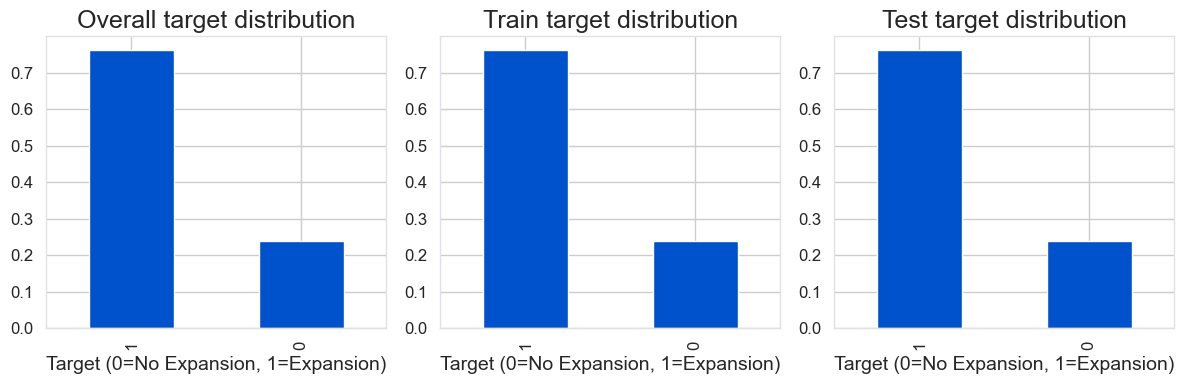

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

y.value_counts(normalize=True).plot(kind="bar", ax=ax[0], title="Overall target distribution")
y_train.value_counts(normalize=True).plot(kind="bar", ax=ax[1], title="Train target distribution")
y_test.value_counts(normalize=True).plot(kind="bar", ax=ax[2], title="Test target distribution")

for a in ax: a.set_xlabel("Target (0=No Expansion, 1=Expansion)")
plt.tight_layout()
plt.show()


# Correlation Heatmap

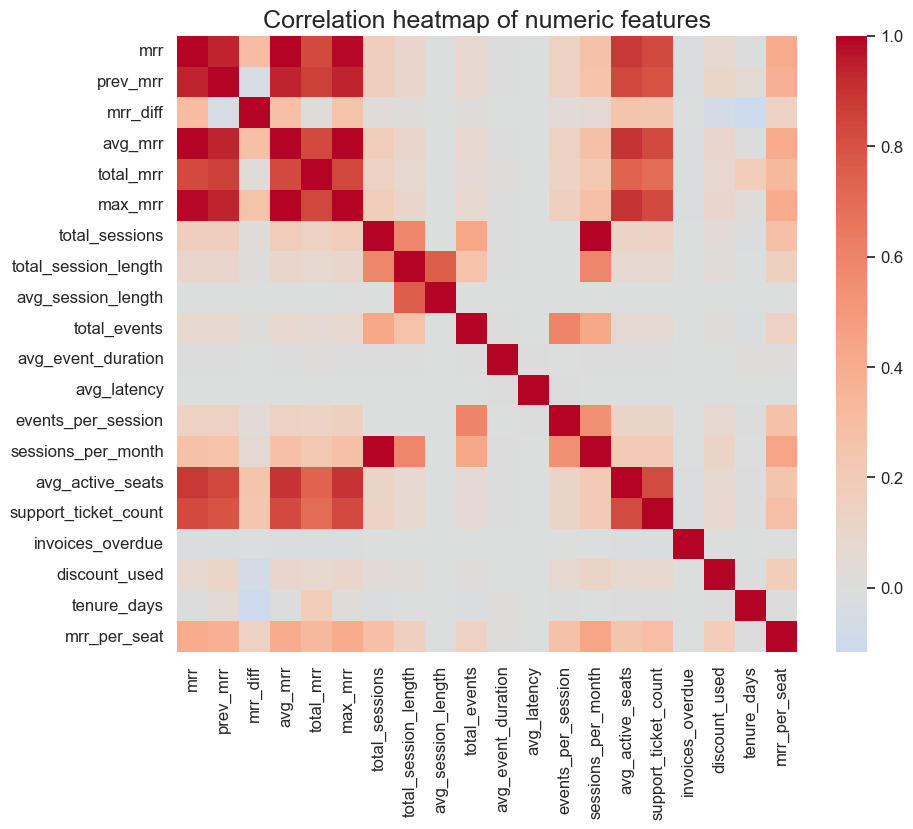

In [28]:
corr = X_train[num_feats].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation heatmap of numeric features")
plt.show()


In [30]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", ohe)
])

pre = ColumnTransformer([
    ("num", num_pipe, num_feats),
    ("cat", cat_pipe, cat_feats)
])

pre.fit(X_train)
Xtr = pre.transform(X_train)
Xte = pre.transform(X_test)


# Tensors

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xt_train = torch.tensor(Xtr.astype("float32")).to(device)
yt_train = torch.tensor(y_train.values.astype("float32")).unsqueeze(1).to(device)
Xt_test  = torch.tensor(Xte.astype("float32")).to(device)
yt_test  = torch.tensor(y_test.values.astype("float32")).unsqueeze(1).to(device)

train_loader = DataLoader(TensorDataset(Xt_train, yt_train), batch_size=1024, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xt_test, yt_test), batch_size=1024, shuffle=False)


# Define Model

In [32]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, hidden=[256,128], dropout=0.3):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.BatchNorm1d(h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model = MLP(Xtr.shape[1]).to(device)


In [33]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, classification_report
import time

# count class balance for pos_weight
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
if pos > 0:
    pos_weight = torch.tensor([neg / pos], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
    criterion = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# convert arrays to tensors
Xt_train = torch.tensor(Xtr.astype("float32"))
yt_train = torch.tensor(y_train.values.astype("float32")).unsqueeze(1)
Xt_test  = torch.tensor(Xte.astype("float32"))
yt_test  = torch.tensor(y_test.values.astype("float32")).unsqueeze(1)

# dataloaders
train_loader = DataLoader(TensorDataset(Xt_train, yt_train), batch_size=1024, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xt_test, yt_test), batch_size=1024, shuffle=False)

# training loop
epochs = 20
best_auc, best_state = 0.0, None

for ep in range(1, epochs+1):
    model.train()
    epoch_loss, t0 = 0.0, time.time()
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    
    # evaluation on test set
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            all_probs.extend(probs)
            all_labels.extend(yb.numpy().ravel())
    
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else float("nan")
    if auc > best_auc:
        best_auc, best_state = auc, model.state_dict()
    print(f"Epoch {ep}/{epochs} | Loss={epoch_loss:.4f} | Test AUC={auc:.4f} | Time={time.time()-t0:.1f}s")

# reload best model
if best_state is not None:
    model.load_state_dict(best_state)

# final evaluation
model.eval()
probs, labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs.extend(torch.sigmoid(logits).cpu().numpy().ravel())
        labels.extend(yb.numpy().ravel())

preds = (np.array(probs) >= 0.5).astype(int)
print("Final Test ROC AUC:", roc_auc_score(labels, probs))
print("Classification Report:")
print(classification_report(labels, preds, zero_division=0))


Epoch 1/20 | Loss=0.1765 | Test AUC=0.9252 | Time=11.4s
Epoch 2/20 | Loss=0.1664 | Test AUC=0.9271 | Time=12.7s
Epoch 3/20 | Loss=0.1645 | Test AUC=0.9296 | Time=12.9s
Epoch 4/20 | Loss=0.1628 | Test AUC=0.9309 | Time=13.5s
Epoch 5/20 | Loss=0.1616 | Test AUC=0.9322 | Time=12.5s
Epoch 6/20 | Loss=0.1606 | Test AUC=0.9343 | Time=11.7s
Epoch 7/20 | Loss=0.1590 | Test AUC=0.9358 | Time=12.0s
Epoch 8/20 | Loss=0.1564 | Test AUC=0.9394 | Time=13.6s
Epoch 9/20 | Loss=0.1536 | Test AUC=0.9413 | Time=12.2s
Epoch 10/20 | Loss=0.1520 | Test AUC=0.9434 | Time=11.7s
Epoch 11/20 | Loss=0.1504 | Test AUC=0.9446 | Time=12.1s
Epoch 12/20 | Loss=0.1489 | Test AUC=0.9464 | Time=11.9s
Epoch 13/20 | Loss=0.1471 | Test AUC=0.9485 | Time=11.8s
Epoch 14/20 | Loss=0.1460 | Test AUC=0.9485 | Time=11.5s
Epoch 15/20 | Loss=0.1449 | Test AUC=0.9509 | Time=11.0s
Epoch 16/20 | Loss=0.1437 | Test AUC=0.9515 | Time=10.9s
Epoch 17/20 | Loss=0.1431 | Test AUC=0.9515 | Time=12.1s
Epoch 18/20 | Loss=0.1423 | Test AUC=0.9

# Save Artifacts

In [37]:
import joblib
import torch

# save preprocessing pipeline
joblib.dump(pre, "expansion_preprocessor.joblib")

# save features used in training
joblib.dump({"num_feats": num_feats, "cat_feats": cat_feats}, "expansion_features.joblib")

# save trained model weights
torch.save(model.state_dict(), "expansion_mlp.pt")


# Predicting Expansion on New Data

In [ ]:
# reuse your MLP class
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden=[256,128], dropout=0.3):
        super().__init__()
        layers, prev = [], input_dim
        for h in hidden:
            layers += [torch.nn.Linear(prev, h), torch.nn.BatchNorm1d(h), torch.nn.ReLU(), torch.nn.Dropout(dropout)]
            prev = h
        layers.append(torch.nn.Linear(prev, 1))
        self.net = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

def predict_expansion(new_df, model_path="expansion_mlp.pt",
                      preproc_path="expansion_preprocessor.joblib",
                      feats_path="expansion_features.joblib",
                      device=None):
    """
    Score new user-month rows for expansion likelihood.
    
    new_df: pandas DataFrame containing raw user-month features
    returns: DataFrame with an added 'expansion_score' column (0–1)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # load preprocessor + features
    pre = joblib.load(preproc_path)
    feat_dict = joblib.load(feats_path)
    num_feats, cat_feats = feat_dict["num_feats"], feat_dict["cat_feats"]

    # preprocess new data
    X_new = pre.transform(new_df[num_feats + cat_feats])
    Xt_new = torch.tensor(X_new.astype("float32")).to(device)

    # rebuild model
    model = MLP(input_dim=X_new.shape[1]).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # predict probabilities
    with torch.no_grad():
        probs = torch.sigmoid(model(Xt_new)).cpu().numpy().ravel()

    # attach scores
    out = new_df.copy()
    out["expansion_score"] = probs
    return out


In [39]:
# pick 10 random rows from your user_month table
new_user_month = user_month.sample(10, random_state=42).copy()

# keep only the features the model expects
all_feats = num_feats + cat_feats
new_user_month = new_user_month[["user_id","month"] + all_feats]

# preview
print(new_user_month.head(3))


                                     user_id      month    mrr  prev_mrr  \
472694  7990badb-6a08-405d-8f1b-222066da53b0 2024-11-01  512.0     520.0   
277082  92dc4d68-cd39-4e01-b1f2-8c3289f0a59e 2024-12-01  315.0     315.0   
682181  4855d735-374f-4818-b60d-e5a2557147c6 2024-09-01   72.0      51.2   

        mrr_diff     avg_mrr  total_mrr  max_mrr  total_sessions  \
472694      -8.0  496.457143     3475.2    520.0             1.0   
277082       0.0  296.454545     3261.0    330.0             2.0   
682181      20.8   57.333333      344.0     72.0             1.0   

        total_session_length  ...  invoices_overdue  discount_used  \
472694                1033.0  ...                 0              0   
277082                1676.0  ...                 0              0   
682181                 613.0  ...                 0              0   

        tenure_days  mrr_per_seat  most_common_device  most_common_os  \
472694          160           8.0             missing         missin

# Predicting Expansion Score

In [ ]:
scored = predict_expansion(new_user_month)

# sort descending (highest likelihood first)
scored_sorted = scored.sort_values("expansion_score", ascending=False)

print(scored_sorted[["user_id", "month", "expansion_score"]])



                                     user_id      month  expansion_score
415138  ba3a0119-5a0e-4704-9565-b28f946f8bea 2025-06-01         0.997075
889157  21324dbd-138a-47a8-a4e6-f96cc8094be8 2025-03-01         0.948798
889437  71f16cb8-d341-48f9-b456-9378146a4db6 2024-06-01         0.932002
551353  a4cbcb4a-750d-4749-9c46-c4f91a3144ea 2024-09-01         0.913684
682181  4855d735-374f-4818-b60d-e5a2557147c6 2024-09-01         0.881686
277082  92dc4d68-cd39-4e01-b1f2-8c3289f0a59e 2024-12-01         0.339541
774283  e240d59d-1c61-4018-b8bc-bd6cf75f7a85 2024-05-01         0.166684
472694  7990badb-6a08-405d-8f1b-222066da53b0 2024-11-01         0.024980
241609  4124bb67-321c-45dd-b2dc-8388837d0ee0 2025-03-01         0.023814
672640  fbb51aca-9365-42e9-bcf4-803b75f2d811 2025-07-01         0.010450


C:\Users\malcolm\AppData\Local\Temp\ipykernel_28596\2766883552.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location

The expansion score is a 0–1 likelihood that an account will upgrade soon. Scores near 1.0 mean the account looks very likely to expand; scores around 0.6–0.8 are promising and worth nurturing; scores near 0.0 mean expansion is unlikely right now. The model calculates this from each account’s recent patterns—things like seats, MRR level/history, and plan—so you can rank customers and focus outreach on the highest-scoring ones first.

# Feature Importance

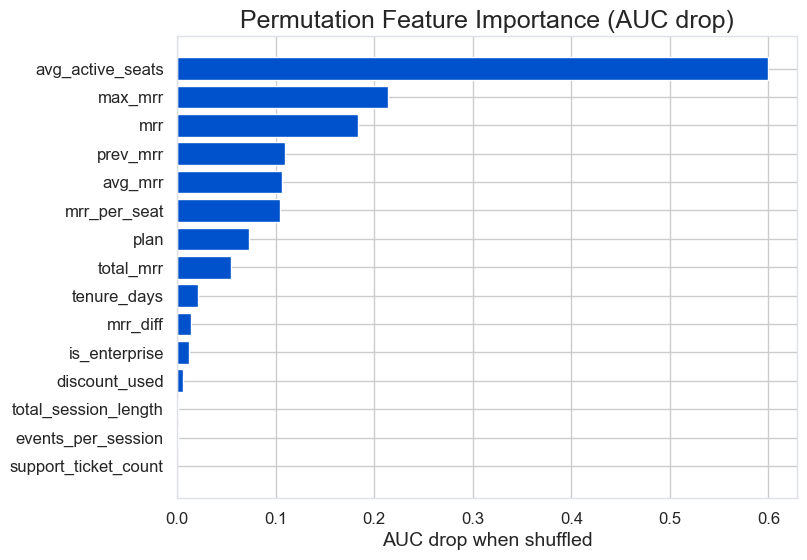

In [45]:
from sklearn.metrics import roc_auc_score
import numpy as np

def permutation_importance(model, X, y, pre, num_feats, cat_feats, n_repeats=5):
    baseline_probs = torch.sigmoid(model(torch.tensor(pre.transform(X).astype("float32")))).detach().numpy().ravel()
    baseline_auc = roc_auc_score(y, baseline_probs)

    importances = {}
    for feat in num_feats + cat_feats:
        scores = []
        for _ in range(n_repeats):
            X_perm = X.copy()
            X_perm[feat] = np.random.permutation(X_perm[feat].values)
            probs = torch.sigmoid(model(torch.tensor(pre.transform(X_perm).astype("float32")))).detach().numpy().ravel()
            scores.append(roc_auc_score(y, probs))
        importances[feat] = baseline_auc - np.mean(scores)
    return importances

# run on a subset to save time
importances = permutation_importance(model, X_test.sample(5000, random_state=42), y_test.sample(5000, random_state=42), pre, num_feats, cat_feats)

# plot
import matplotlib.pyplot as plt
imp_sorted = sorted(importances.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*imp_sorted[:15])  # top 15
plt.figure(figsize=(8,6))
plt.barh(features, scores)
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance (AUC drop)")
plt.xlabel("AUC drop when shuffled")
plt.show()


This chart ranks which attributes the model leans on most to predict upgrades: scrambling avg_active_seats hurts accuracy the most, so steady seat count is the strongest upgrade signal; next are revenue levels—max_mrr, current mrr, prev_mrr, avg_mrr, and mrr_per_seat—meaning accounts already spending more (or historically higher) are likelier to expand; plan has a moderate effect; while tenure_days, mrr_diff, is_enterprise, discount_used, session/usage metrics, and support_ticket_count barely change accuracy when shuffled, so they add little predictive power here. Business takeaway: focus upsell efforts on growing teams with higher spend; other signals matter less in this dataset.